In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
import missingno as mso
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import pandas as pd

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
data = pd.read_csv("/content/drive/MyDrive/ML/seattle-weather.csv")

In [57]:
# Number of rows and columns

data.shape

(1461, 6)

In [58]:
data = data[data['weather'].isin(['sun', 'rain'])]

In [59]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1281 entries, 1 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1281 non-null   object 
 1   precipitation  1281 non-null   float64
 2   temp_max       1281 non-null   float64
 3   temp_min       1281 non-null   float64
 4   wind           1281 non-null   float64
 5   weather        1281 non-null   object 
dtypes: float64(4), object(2)
memory usage: 70.1+ KB


In [60]:
# Data Statistical Summary
data.describe()

,precipitation,temp_max,temp_min,wind
count,1281.000000,1281.000000,1281.000000,1281.000000
mean,3.281499,16.655738,8.465574,3.313427
std,6.939005,7.226486,4.870935,1.435877
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,11.100000,5.000000,2.300000
50%,0.000000,15.600000,8.300000,3.000000
75%,3.300000,22.200000,12.200000,4.100000
max,55.900000,35.600000,18.300000,9.500000


In [61]:
# Missing values summary

data.isna().sum()

,0
date,0
precipitation,0
temp_max,0
temp_min,0
wind,0
weather,0


In [62]:
data['weather'].value_counts()

,count
weather,
rain,641
sun,640


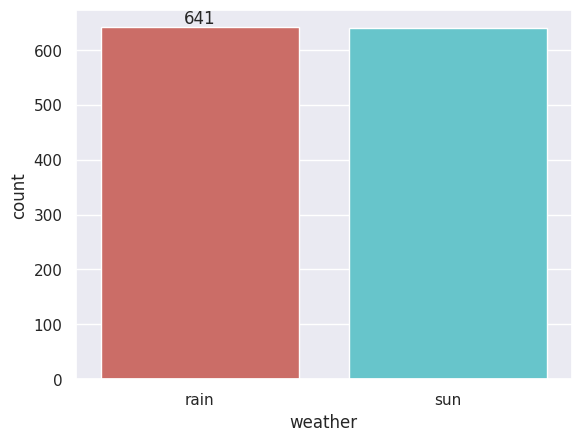

In [63]:
import warnings
warnings.filterwarnings('ignore')
ax = sns.countplot(x = 'weather', data=data,palette='hls')
ax.bar_label(ax.containers[0]);

In [64]:
countrain=len(data[data.weather=='rain'])
countsun=len(data[data.weather=='sun'])
countdrizzle=len(data[data.weather=='drizzle'])
countsnow=len(data[data.weather=='snow'])
countfog=len(data[data.weather=='fog'])
print('percent of rain:{:2f}%'.format((countrain/(len(data.weather))*100)))
print('percent of sun:{:2f}%'.format((countsun/(len(data.weather))*100)))
print('percent of drizzle:{:2f}%'.format((countdrizzle/(len(data.weather))*100)))
print('percent of snow:{:2f}%'.format((countsnow/(len(data.weather))*100)))
print('percent of fog:{:2f}%'.format((countfog/(len(data.weather))*100)))

percent of rain:50.039032%
percent of sun:49.960968%
percent of drizzle:0.000000%
percent of snow:0.000000%
percent of fog:0.000000%


<Axes: xlabel='wind', ylabel='Count'>

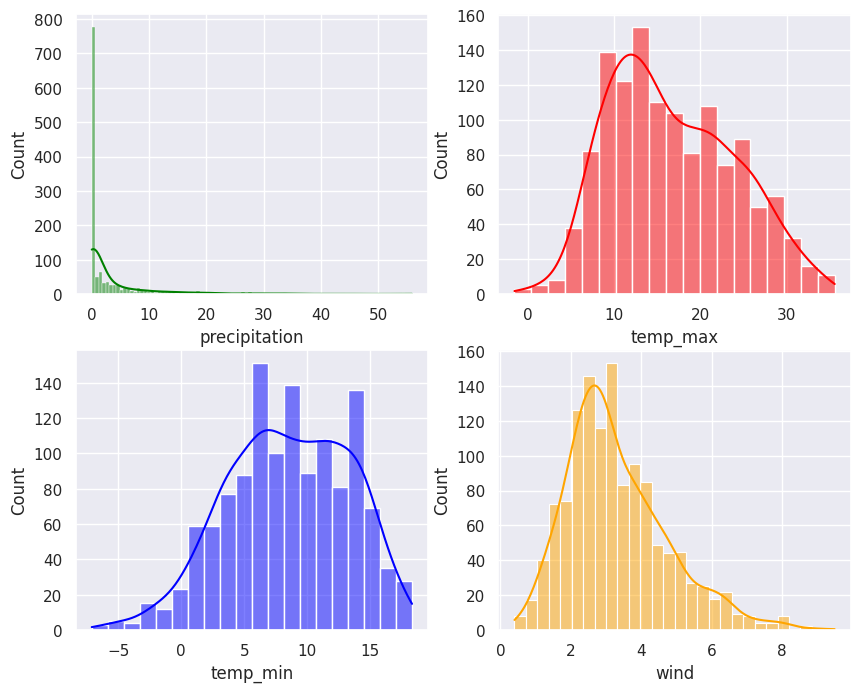

In [65]:
sns.set(style='darkgrid')
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=data,x='precipitation',kde=True,ax=axs[0,0],color='green')
sns.histplot(data=data,x='temp_max',kde=True,ax=axs[0,1],color='red')
sns.histplot(data=data,x='temp_min',kde=True,ax=axs[1,0],color='blue')
sns.histplot(data=data,x='wind',kde=True,ax=axs[1,1],color='orange')

<Axes: xlabel='wind'>

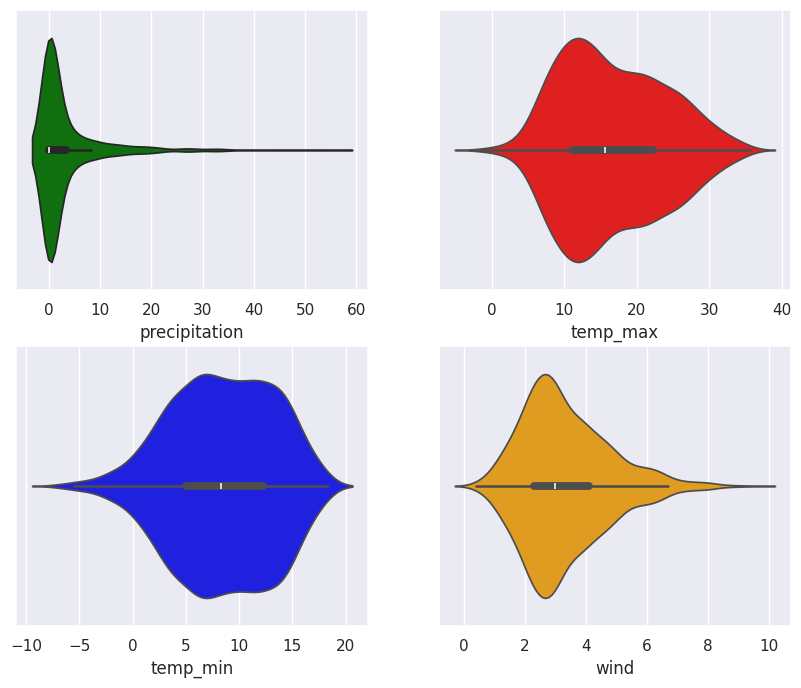

In [66]:
sns.set(style='darkgrid')
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.violinplot(data=data,x='precipitation',ax=axs[0,0],color='green') # Removed kde=True
sns.violinplot(data=data,x='temp_max',ax=axs[0,1],color='red') # Removed kde=True
sns.violinplot(data=data,x='temp_min',ax=axs[1,0],color='blue') # Removed kde=True
sns.violinplot(data=data,x='wind',ax=axs[1,1],color='orange') # Removed kde=True

<Axes: xlabel='precipitation', ylabel='weather'>

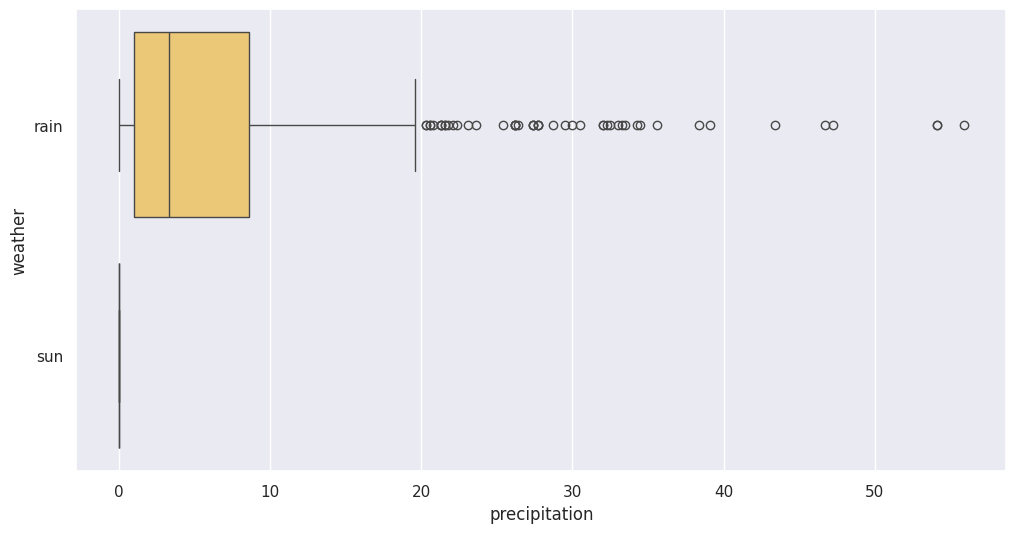

In [67]:
plt.figure(figsize=(12,6))
sns.boxplot(x='precipitation',y='weather',data=data,palette='YlOrBr')

<Axes: xlabel='temp_max', ylabel='weather'>

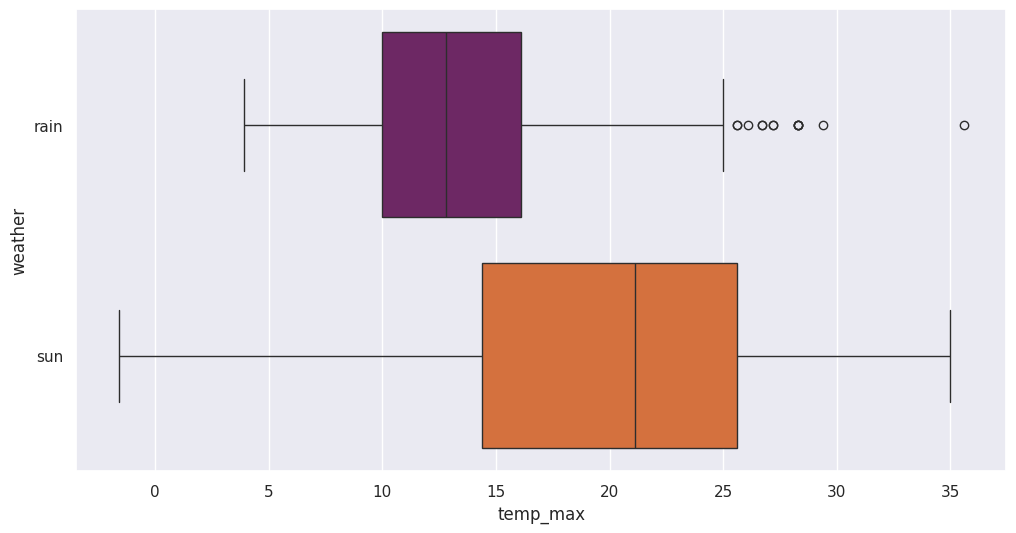

In [68]:
plt.figure(figsize=(12,6))
sns.boxplot(x='temp_max',y='weather',data=data,palette='inferno')

<Axes: xlabel='wind', ylabel='weather'>

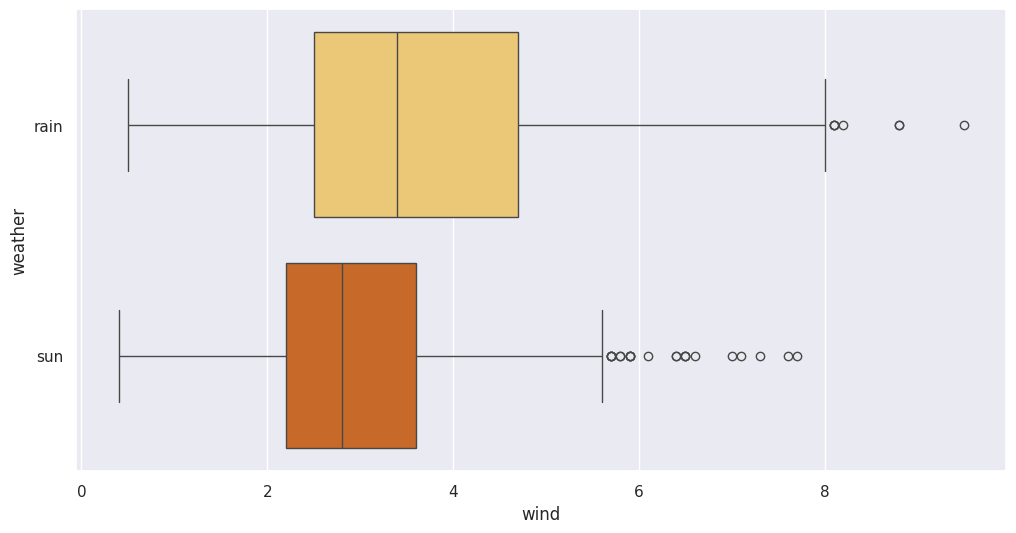

In [69]:
plt.figure(figsize=(12,6))
sns.boxplot(x='wind',y='weather',data=data,palette='YlOrBr')

<Axes: xlabel='temp_min', ylabel='weather'>

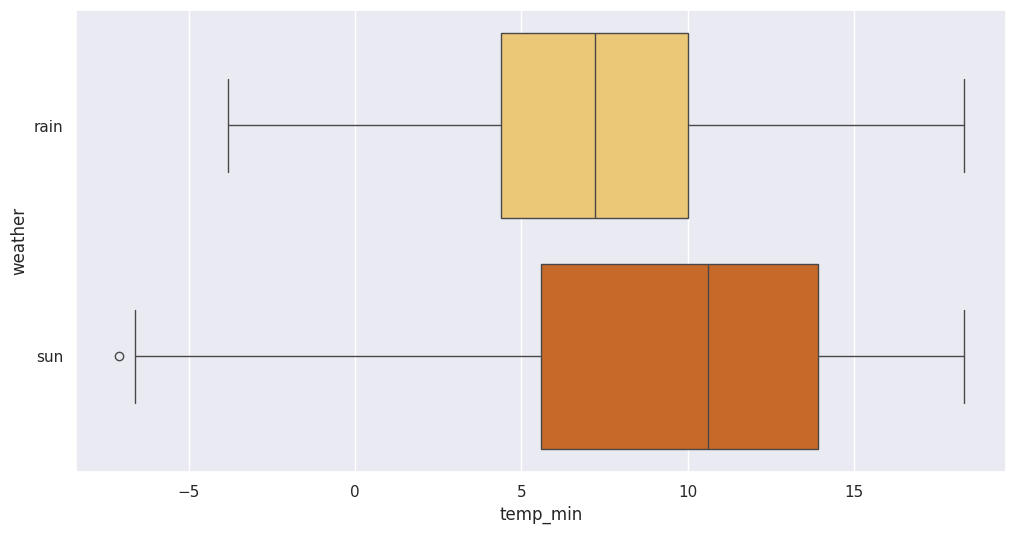

In [70]:
plt.figure(figsize=(12,6))
sns.boxplot(x='temp_min',y='weather',data=data,palette='YlOrBr')

In [71]:
data

,date,precipitation,temp_max,temp_min,wind,weather
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
5,2012-01-06,2.5,4.4,2.2,2.2,rain
...,...,...,...,...,...,...
1455,2015-12-26,0.0,4.4,0.0,2.5,sun
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [72]:
data[['precipitation', 'temp_max', 'temp_min', 'wind']].corr()

,precipitation,temp_max,temp_min,wind
precipitation,1.000000,-0.233334,-0.066462,0.312007
temp_max,-0.233334,1.000000,0.864699,-0.186461
temp_min,-0.066462,0.864699,1.000000,-0.085976
wind,0.312007,-0.186461,-0.085976,1.000000


<Axes: >

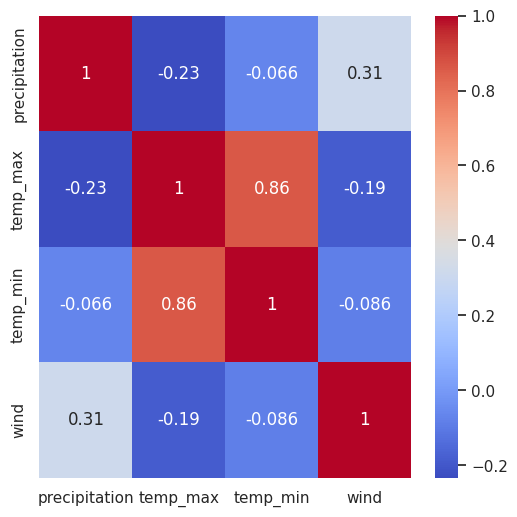

In [73]:
plt.figure(figsize=(6,6))
sns.heatmap(data[['precipitation', 'temp_max', 'temp_min', 'wind']].corr(),annot=True,cmap='coolwarm')

pearsons correlation:  -0.23333415338216157
T test and P value:  TtestResult(statistic=-47.77906009795803, pvalue=0.0, df=2560.0)


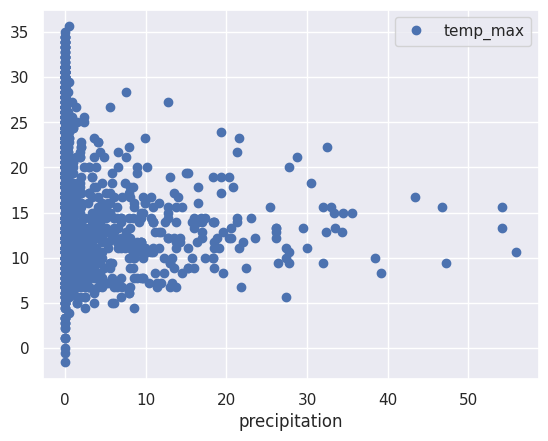

In [74]:
data.plot("precipitation",'temp_max',style='o')
print('pearsons correlation: ',data['precipitation'].corr(data['temp_max']))
print('T test and P value: ',stats.ttest_ind(data['precipitation'],data['temp_max']))

pearsons correlation:  -0.186460737579839
T test and P value:  TtestResult(statistic=-64.81422788709385, pvalue=0.0, df=2560.0)


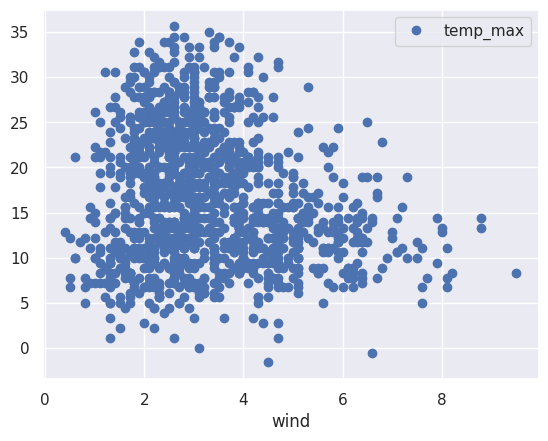

In [75]:
data.plot("wind",'temp_max',style='o')
print('pearsons correlation: ',data['wind'].corr(data['temp_max']))
print('T test and P value: ',stats.ttest_ind(data['wind'],data['temp_max']))

<Axes: xlabel='temp_max'>

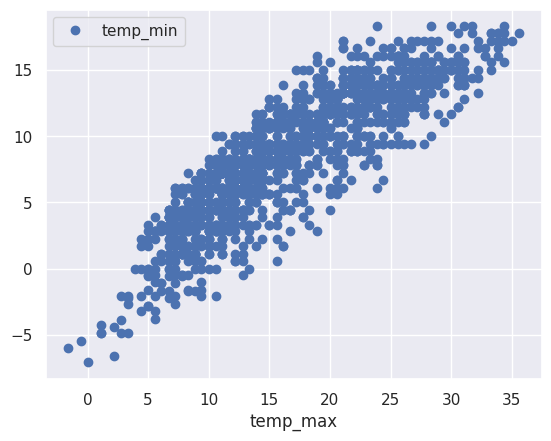

In [76]:
data.plot('temp_max','temp_min',style='o')

In [77]:
data.isna().sum()

,0
date,0
precipitation,0
temp_max,0
temp_min,0
wind,0
weather,0


<Axes: >

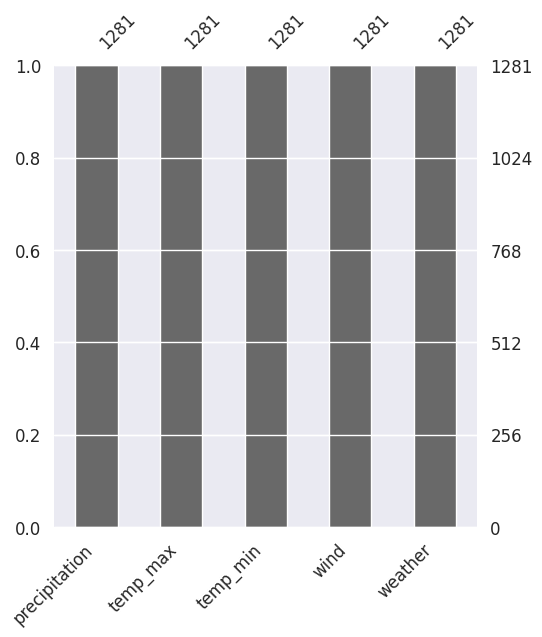

In [78]:
plt.figure(figsize=(12,6))
axz=plt.subplot(1,2,2)
mso.bar(data.drop(['date'],axis=1),ax=axz,fontsize=12)

In [79]:
data=data.drop(['date'],axis=1)

In [80]:

# Q1=data.quantile(0.25)
# Q3=data.quantile(0.75)
# IQR=Q3-Q1
# data=data[~((data<(Q1-1.5*IQR))|(data>(Q3+1.5*IQR))).any(axis=1)]

In [81]:
import numpy as np
data.precipitation=np.sqrt(data.precipitation)
data.wind=np.sqrt(data.wind)

<Axes: xlabel='wind', ylabel='Count'>

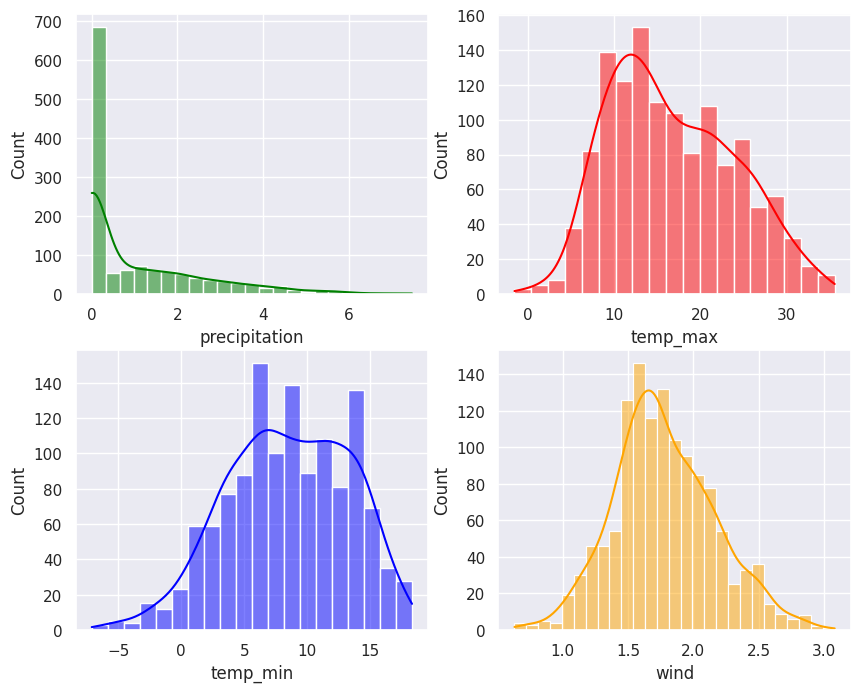

In [82]:
sns.set(style='darkgrid')
fig, axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=data,x="precipitation",kde=True,ax=axs[0,0],color='green')
sns.histplot(data=data,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.histplot(data=data,x="temp_min",kde=True,ax=axs[1,0],color='blue')
sns.histplot(data=data,x="wind",kde=True,ax=axs[1,1],color='orange')

In [83]:
data.head()

,precipitation,temp_max,temp_min,wind,weather
1,3.301515,10.6,2.8,2.121320,rain
2,0.894427,11.7,7.2,1.516575,rain
3,4.505552,12.2,5.6,2.167948,rain
4,1.140175,8.9,2.8,2.469818,rain
5,1.581139,4.4,2.2,1.483240,rain


In [84]:
lc=LabelEncoder()
data['weather']=lc.fit_transform(data['weather'])

In [85]:
data.head()

,precipitation,temp_max,temp_min,wind,weather
1,3.301515,10.6,2.8,2.121320,0
2,0.894427,11.7,7.2,1.516575,0
3,4.505552,12.2,5.6,2.167948,0
4,1.140175,8.9,2.8,2.469818,0
5,1.581139,4.4,2.2,1.483240,0


In [86]:
x=((data.loc[:,data.columns!='weather']).astype(int)).values[:,0:]
y=data['weather'].values

In [87]:
data.weather.unique()

array([0, 1])

In [88]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=2)

In [89]:
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
print('KNN accuracy:{:.2f}%'.format(knn.score(x_test,y_test)*100))

KNN accuracy:81.40%


In [95]:
input=[[1.140175,8.9,2.8,2.469818]]
ot=xgb.predict(input)
print('the weather is:')
if(ot==0):
  print('rain')
else:
  print('sun')

the weather is:
rain


In [96]:
import pickle
with open('knn_model.pkl', 'wb') as file:
    pickle.dump(knn, file)